# A COVID-19 Prediction Model Using Symptoms

In [23]:
import pandas as pd
import zipfile
import numpy as np

### The Dataset

The data (sourced [here](https://github.com/nshomron/covidpred)) is from the paper [Machine learning-based prediction of Covid-19 diagnosis based on symptoms](https://www.nature.com/articles/s41746-020-00372-6.pdf)

# Exploratory Data Analysis

### Part 1: Load Data, Data Analysis and Processing

In [14]:
zf = zipfile.ZipFile("/content/drive/My Drive/Colab Notebooks/corona_tested_individuals_ver_00220.english.zip")

df = pd.read_csv(zf.open("corona_tested_individuals_ver_00220.english.csv"),low_memory=False)

In [15]:
zf_smaller = zipfile.ZipFile("/content/drive/My Drive/Colab Notebooks/corona_tested_individuals_ver_0083.english.zip")
df_smaller = pd.read_csv((zf.open("/data/corona_tested_individuals_ver_0083.csv"), low_memory=False)

In [ ]:
#pip install pandas-profiling==2.7.1

In [ ]:
#!pip install pandas-profiling[notebook]

In [16]:
df.head()

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication
0,2022-01-30,0,0,0,0,0,positive,No,female,Other
1,2022-01-30,0,0,0,0,0,positive,No,female,Other
2,2022-01-30,0,0,0,0,0,positive,No,male,Other
3,2022-01-30,0,0,0,0,0,positive,No,female,Other
4,2022-01-30,0,0,0,0,0,positive,No,female,Other


In [17]:
from pandas_profiling import ProfileReport
#Generate the report

profile = ProfileReport(df)
profile

Summarize dataset:   0%|          | 0/22 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [55]:
from sklearn.model_selection import train_test_split

def preprocess_data(df):
    df = df.drop("test_date", axis=1)

    df["corona_result"] = df["corona_result"].map({"negative": 0, "positive": 1, "other": np.nan})
    df = df.dropna()
    df["age_60_and_above"] = df["age_60_and_above"].map({"No": 0, "Yes": 1})
    df["gender"] = df["gender"].map({"female": 1, "male": 0})

    df = pd.get_dummies(df)

    df = df.rename(columns={"test_indication_Contact with confirmed": "contact_with_confirmed", "test_indication_Abroad": "abroad", "test_indication_Other": "other"})

    y = df["corona_result"]
    X = df.drop("corona_result", axis=1)

    return X, y

def split_data(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

    return X_train, X_test, y_train, y_test

In [32]:
df["corona_result"].value_counts()

negative    7856225
positive     800109
other        233967
Name: corona_result, dtype: int64

Split the data into `X_train`, `X_test`, `y_train`, `y_test` to prepare for training the model.

In [56]:
X, y = preprocess_data(df)
X_train, X_test, y_train, y_test = split_data(X,y)

In [64]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from IPython.display import Image
import pydotplus
import sklearn.tree as tree
import matplotlib.pyplot as plt
import seaborn as sns

def decision_tree(X_train, X_test, y_train, y_test):

    dtc = DecisionTreeClassifier(random_state=42, class_weight={0:1, 1:10})
    dtc.fit(X_train, y_train)

    dtc_y_pred = dtc.predict(X_test)

    print(classification_report(y_test, dtc_y_pred))

    dt_cm = confusion_matrix(dtc_y_pred, y_test)
    print('Decision Tree confusion matrix:')
    sns.heatmap(dt_cm/np.sum(dt_cm), annot=True, 
                fmt='.2%', cmap='Blues')

    fpr, tpr, thresholds = roc_curve(y_test, dtc_y_pred, pos_label=1)

    auc = roc_auc_score(y_test, dtc_y_pred)

    fig, ax = plt.subplots()
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='navy', linestyle='--', label='random')
    plt.title(f'AUC: {auc}')
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')

    dt_feature_names = list(X.columns)
    dt_target_names = [str(s) for s in y.unique()]
    tree.export_graphviz(dtc, out_file='tree.dot', 
        feature_names=dt_feature_names, class_names=dt_target_names,
        filled=True, max_depth = 4)  
    graph = pydotplus.graph_from_dot_file('tree.dot')
    Image(graph.create_png())

    return dtc

              precision    recall  f1-score   support

         0.0       0.93      0.90      0.92    581369
         1.0       0.38      0.46      0.42     75319

    accuracy                           0.85    656688
   macro avg       0.66      0.68      0.67    656688
weighted avg       0.87      0.85      0.86    656688

Decision Tree confusion matrix:


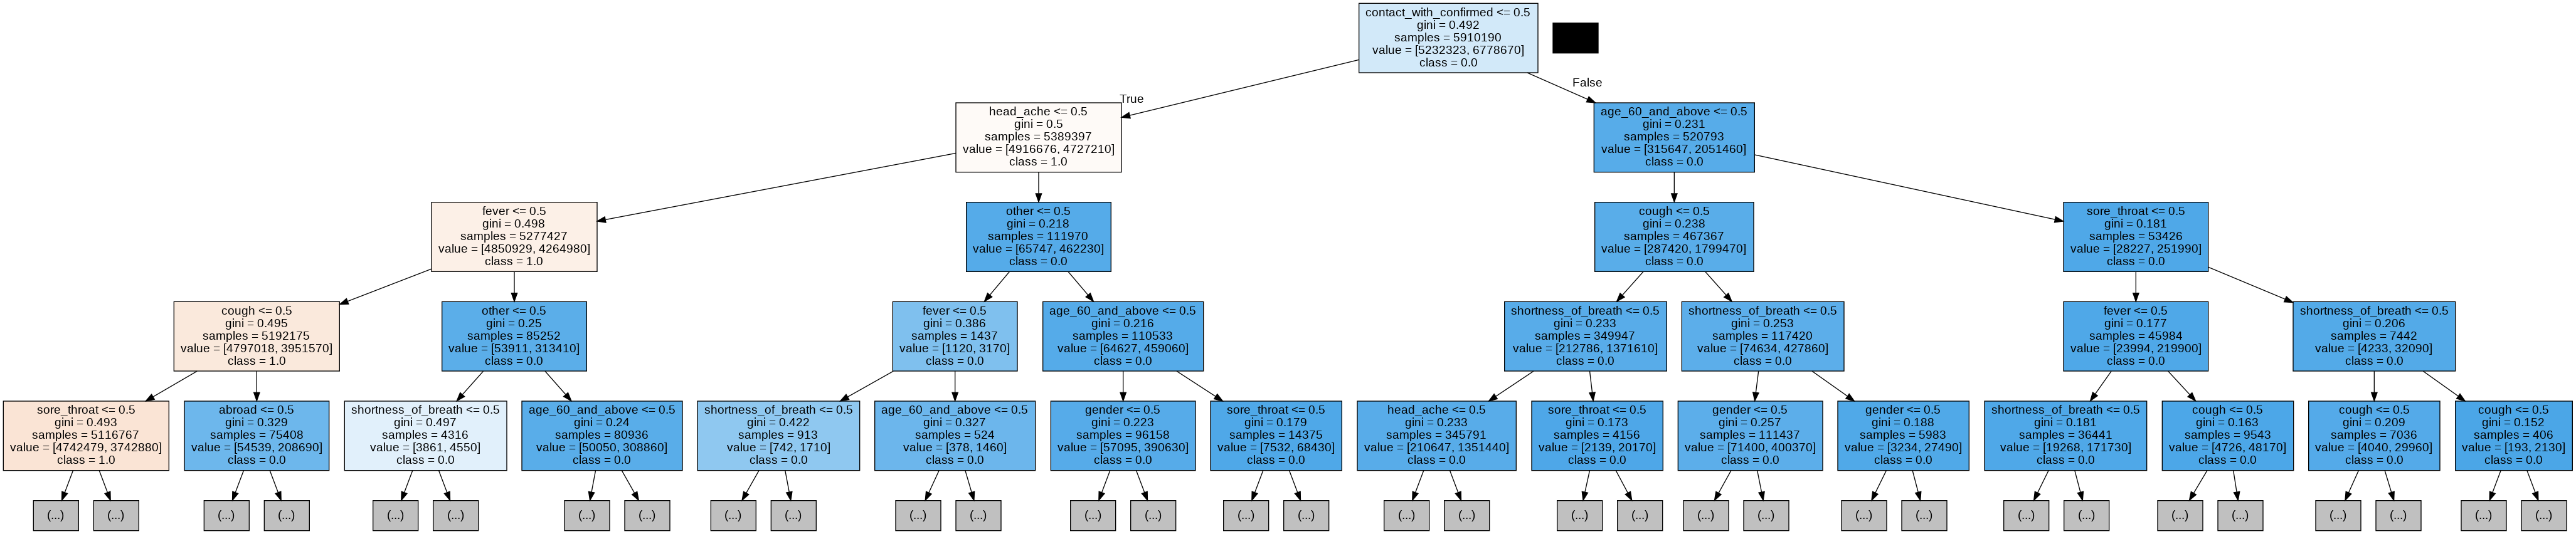

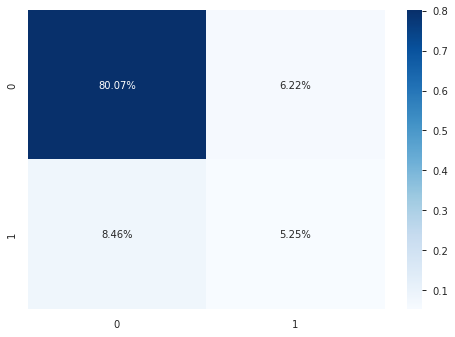

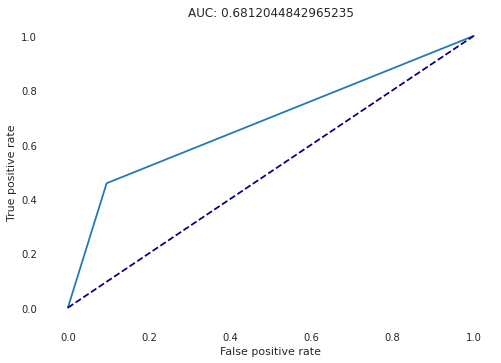

In [69]:
import pydotplus
import sklearn.tree as tree
from IPython.display import Image

dtc = decision_tree(X_train, X_test, y_train, y_test)

dt_feature_names = list(X.columns)
dt_target_names = [str(s) for s in y.unique()]
tree.export_graphviz(dtc, out_file='tree.dot', 
    feature_names=dt_feature_names, class_names=dt_target_names,
    filled=True, max_depth = 4)  
graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())

Train the model on the smaller dataset.

In [ ]:
X, y = preprocess_data(df_smaller)
X_train, X_test, y_train, y_test = split_data(X,y)

In [ ]:
dtc = decision_tree(X_train, X_test, y_train, y_test)

dt_feature_names = list(X.columns)
dt_target_names = [str(s) for s in y.unique()]
tree.export_graphviz(dtc, out_file='tree.dot', 
    feature_names=dt_feature_names, class_names=dt_target_names,
    filled=True, max_depth = 4)  
graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())